In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mnist import MNIST
import random

In [2]:
def count_numspercent(num, arr):
    print(np.count_nonzero(arr == num)/len(arr))

In [3]:
mndata = MNIST("dat")
train = np.array(mndata.load_training()).T
test = np.array(mndata.load_testing()).T

testLabels = test[:, 1]

for i in range(10):
    count_numspercent(i, testLabels)
    
# print(type(test[0]))

0.098
0.1135
0.1032
0.101
0.0982
0.0892
0.0958
0.1028
0.0974
0.1009


In [4]:
def printShape(name, arr):
    print("{0} shape:".format(name) + str(arr.shape))

class NeuralNetwork(object):
    def __init__(self, sizes):
        """
        constructor for a neural network.
        from https://github.com/mnielsen/neural-networks-and-deep-learning/
             blob/master/src/network.py
        """
        self.nLayers = len(sizes)
        self.sizes = sizes
        
        # array of bias vectors, list with `nLayers` amount of vecs
        # containing `size` elements
        
        self.biases = [np.random.randn(nextSize, 1) \
                       for nextSize in sizes[1:]]
        
        # array of weight matrices, if the previous layer is 
        # sized a, and next layer b, the weight matrix would
        # be sized (b * a) to accomodate transformation
        # (b * 1) = (b * a) . (a * 1)
        
        self.weights = [np.random.randn(nextSize, prevSize) \
                        for prevSize, nextSize in zip(sizes[:-1], sizes[1:])]
    
    def stochasticGradDesc(self, trainDat, nEpoch, sSSize, rate, testDat = None):
        
        print("starting ...")
        
        if testDat is not None: 
            nTest = len(testDat)
            percent_list = []
        
        nTrain = len(trainDat)
        
        for i in range(nEpoch):
            random.shuffle(trainDat)
            
            subSets = [train[k : k + sSSize] for k in range(0, nTrain, sSSize)]
            
            for subSet in subSets:
                self.updSubSet(subSet, rate)
                
            if testDat is not None:
                percent = self.evaluate(testDat)/nTest
                print("Epoch {0} accuracy: {1:.1%} = 100 * {2}/{3}.".format( \
                    i, percent, self.evaluate(testDat), nTest))
                percent_list.append(percent)
            
            else:
                print("Epoch {0} complete".format(i))
                
        plt.plot(np.arange(nEpoch), percent_list, "k--")
        print(percent_list)
        print("end.")
        plt.show()
        
    def feedFwd(self, arr):
        """
        forward feeding
        """
        arr = np.array([arr]).T
        # printShape("input_arr", arr)
        
        # i = 0 
        
        for b, w in zip(self.biases, self.weights):
            z = w @ arr + b
            # printShape("weight {0}".format(i), w)
            arr = self.smd(z)
            # printShape("output_arr {0}".format(i), arr)
            # i += 1
            
        # print(arr)
        # print("end")
        
        return arr

    def evaluate(self, testDat):
        results = [(np.argmax(self.feedFwd(x)), y) for (x, y) in testDat]
        # tuple (int, int)
        return sum(int(x == y) for x, y in results)
        
        
    def updSubSet(self, subSet, rate):
        
        # initialise weight gradients and bias gradients
        
        nabB = [np.zeros(b.shape) for b in self.biases]
        nabW = [np.zeros(w.shape) for w in self.weights]
        
        set_size = len(subSet)
        batch_rate = rate/set_size
        
        # update
        
        for x, y in subSet:
            delNabB, delNabW = self.propBwd(x, y)
            
            nabB = [nB + dnB for (nB, dnB) in zip(nabB, delNabB)]
            nabW = [nW + dnW for (nW, dnW) in zip(nabW, delNabW)]
            
            
        self.weights = [Wi - batch_rate * nabWi \
                        for Wi, nabWi in zip(self.weights, nabW)]
        
        self.biases = [Bi - batch_rate * nabBi \
                       for Bi, nabBi in zip(self.biases, nabB)]
        
    def difCost(self, outAct, y):
        return outAct - y # (10 * 1)
        
    def propBwd(self, x, y):
        """
        backwards propagation
        
        x - activation layer: ndarray, size m * 1
        y - output: int, could be converted to ndarray, size 10 * 1
            with oneHot(y).
            
        return:
        """
        
        # initialise weight gradients and bias gradients
        
        nabB = [np.zeros(b.shape) for b in self.biases]
        nabW = [np.zeros(w.shape) for w in self.weights]
        
        # forward propagation
        
        act = np.array([x]).T
        
        acts = [act]
        
        zVecs = []
        
        # feedFwd is not called to store the z and a values
        
        for b, w in zip(self.biases, self.weights):
            z = (w @ act) + b # (m * 1)
            act = self.smd(z)
            
            zVecs.append(z)
            acts.append(act)
            
            
        # bwd; output (acts[-1]) to first hidden (acts[-2])
        delta = self.difCost(acts[-1], self.oneHot(y))
        
        nabW[-1] = delta @ np.array(acts[-2]).T
        nabB[-1] = delta # (out * 1)
        
        # for the rest of the network
        
        for l in range(2, self.nLayers):
            z = zVecs[-l]
            
            delta = (self.weights[-l + 1].T @ delta) * self.difsmd(z)
            
            nabW[-l] = delta @ acts[-l - 1].T # (m * 1). (1 * m) = (m * m)
            nabB[-l] = delta # m * 1
            
        return (nabB, nabW)
    
    
    ####### activation functions #######
            
    def smd(self, z):
        """sigmoid function"""
        return 1 / (1 + np.exp(-z))
    
    def difsmd(self, z):
        return self.smd(z) * (1 - self.smd(z))
    
    def oneHot(self, y):
        arr = np.zeros(10)
        arr[y] = 1
        return np.array([arr]).T
    
    def reLU(self, z):
        return np.maximum(0, z)
    
    def difReLU(self, z):
        if isinstance(z, np.ndarray):
            z = np.array([i > 0 for i in z])
            return z
        
        return z > 0
    
    def softMax(self, z, z_arr):
        sum_exp_arr = sum(np.exp(z_arr))
        
        if isinstance(z, np.ndarray):
            arr = np.array([np.exp(i)/sum_exp_arr for i in z])
            return arr
        
        return np.exp(z)/sum(np.exp(z_arr))
    
    

starting ...


<ipython-input-4-880ccf132511>:172: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 0 accuracy: 36.8% = 100 * 3680/10000.
Epoch 1 accuracy: 49.6% = 100 * 4958/10000.
Epoch 2 accuracy: 55.1% = 100 * 5508/10000.
Epoch 3 accuracy: 61.1% = 100 * 6113/10000.
Epoch 4 accuracy: 61.0% = 100 * 6103/10000.
Epoch 5 accuracy: 59.5% = 100 * 5950/10000.
Epoch 6 accuracy: 60.4% = 100 * 6043/10000.
Epoch 7 accuracy: 60.9% = 100 * 6094/10000.
Epoch 8 accuracy: 60.1% = 100 * 6006/10000.
Epoch 9 accuracy: 58.3% = 100 * 5826/10000.
Epoch 10 accuracy: 58.2% = 100 * 5819/10000.
Epoch 11 accuracy: 56.7% = 100 * 5670/10000.
Epoch 12 accuracy: 56.7% = 100 * 5671/10000.
Epoch 13 accuracy: 56.3% = 100 * 5631/10000.
Epoch 14 accuracy: 54.0% = 100 * 5401/10000.
Epoch 15 accuracy: 53.5% = 100 * 5346/10000.
Epoch 16 accuracy: 52.9% = 100 * 5295/10000.
Epoch 17 accuracy: 49.0% = 100 * 4901/10000.
Epoch 18 accuracy: 48.0% = 100 * 4801/10000.
Epoch 19 accuracy: 45.2% = 100 * 4522/10000.
[0.368, 0.4958, 0.5508, 0.6113, 0.6103, 0.595, 0.6043, 0.6094, 0.6006, 0.5826, 0.5819, 0.567, 0.5671, 0.5631, 

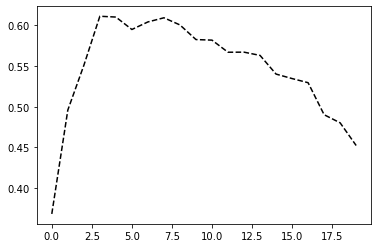

In [5]:
neuNet = NeuralNetwork([784, 16, 16, 10])

neuNet.stochasticGradDesc(train, 20, 10, 0.011, testDat = test)